In [59]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from datetime import datetime
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad

import scipy
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, train_test_split

import tensorflow as tf
from tensorflow.keras import backend as K

In [3]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [96]:
data_paths = ['../DATA/TCGA/TCGA_GDC_HTSeq_TPM.csv',
              '../DATA/METABRIC/METABRIC.csv',
              '../DATA/SDY67/SDY67_468.csv',
              '../DATA/Gene Lists/immport_genelist.csv'] #,
#               '../DATA/Gene Lists/scdata_genelist_filtered_v2.csv']

In [50]:
# Pearson correlation
def pearson_correlation(y_true, y_pred):
    x = y_pred
    y = y_true
    vx = x - K.mean(x)
    vy = y - K.mean(y)
    r = K.sum(vx * vy) / (K.sqrt(K.clip(K.sum(K.square(vx)), K.epsilon(), float('inf'))) * K.sqrt(K.clip(K.sum(K.square(vy)), K.epsilon(), float('inf'))))
    return r

def tilted_loss(y_true, y_pred, q):
    e = (y_true - y_pred)
    return K.mean(K.maximum(q * e, (q - 1) * e), axis=-1)

In [97]:
def FeatureList(paths: list) -> list:
    features = None
    for path in tqdm(paths):
        mydata = pd.read_csv(path, index_col = 0)
        if features == None:
            features = set(mydata.index.values.tolist())
        else:
            features = features.intersection(set(mydata.index.values.tolist()))
    features = list(features)
    features.sort()
    return features

In [98]:
features = FeatureList(data_paths)

100%|██████████| 4/4 [00:15<00:00,  3.81s/it]


In [5]:
X0 = np.loadtxt('../DATA/simbulk/210319_GAN_N100000_C500_simbulk_data.csv', dtype='float', delimiter=',')

In [6]:
Y0 = np.loadtxt('../DATA/simbulk/210319_GAN_N100000_C500_simbulk_label.csv', dtype='float', delimiter=',')

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X0, Y0, test_size=0.1, random_state=77)

In [17]:
CELLTYPES = ['CAF','B_cell','Cancer','Endothelial','Myeloid','Other_T','CD8+_T_cell',
             'NK_cell','CD4+_T_cell','Treg','PVL','Epithelial']
QUANTILES = [0.1,0.25,0.5,0.75,0.9]
BATCH_SIZE = 100
EPOCHS = 10
LEARN_RATE = 1e-3

##### Real data (SDY67)

In [77]:
X0 = pd.read_csv('C:/Users/yw_ji/Documents/MSc Thesis/DATA/SDY67/SDY67_250_pp.csv', index_col=0)
# x = ad.read_h5ad('C:/Users/yw_ji/Documents/MSc Thesis/DATA/scaden_input/simulated_data/data_10000.h5ad')
# X0 = X0.reindex(x.var.index)
X0 = X0.reindex(features)
X0 = X0.T
Y0 = pd.read_csv('C:/Users/yw_ji/Documents/MSc Thesis/DATA/SDY67/SDY67_250_label_pp_7ct.csv', index_col=0)
# Y0 = np.expand_dims(np.array(Y0, dtype=np.float32), axis=-1)

In [78]:
X_train, X_test, Y_train, Y_test = train_test_split(X0, Y0, test_size=0.1, random_state=77)

In [92]:
CELLTYPES = Y0.columns.tolist()
NUM_SIG_GENES = X0.shape[1]
QUANTILES = [0.1,0.25,0.5,0.75,0.9]
BATCH_SIZE = 1
EPOCHS = 100
LEARN_RATE = 1e-5

#### New code training all celltypes simultaneously (May 10, 2021)

In [93]:
outputs = []
x = tf.keras.layers.Input(shape=(NUM_SIG_GENES,), name='Input')
for i in range(len(CELLTYPES)):
    c = CELLTYPES[i]
    output = tf.keras.layers.Flatten(name=f'Flatten_{c}')(x)
    output = tf.keras.layers.Dense(1, activation='linear', bias_constraint=tf.keras.constraints.NonNeg(),
                                   kernel_regularizer=tf.keras.regularizers.l2(0.0001), name=f'Dense_{c}')(output)
    outputs.append(output)

MODEL = tf.keras.Model(inputs=x, outputs=outputs)
MODEL.summary()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 526)]        0                                            
__________________________________________________________________________________________________
Flatten_B_cell (Flatten)        (None, 526)          0           Input[0][0]                      
__________________________________________________________________________________________________
Flatten_T_CD4 (Flatten)         (None, 526)          0           Input[0][0]                      
__________________________________________________________________________________________________
Flatten_T_CD8 (Flatten)         (None, 526)          0           Input[0][0]                      
______________________________________________________________________________________

In [94]:
def train_model(model, data_name, train_data, test_data, q):
    loss_obj = [lambda y,f: tilted_loss(y,f,q)]*len(CELLTYPES)
    optmzr = tf.keras.optimizers.Adam(lr=LEARN_RATE)
    model.compile(optimizer=optmzr, loss=loss_obj,
                 metrics=[pearson_correlation, tf.keras.metrics.RootMeanSquaredError()])
    time = datetime.now().strftime('%Y%m%d')
    if os.path.isdir(f'./log/training/{time}/') is False:
        os.mkdir(f'./log/training/{time}/')
    log_name = f'{time}/{data_name}_{q}'
    callback_csv = tf.keras.callbacks.CSVLogger(filename=f'./log/training/{log_name}.log')
    callback_chk = tf.keras.callbacks.ModelCheckpoint(filepath=f'./log/training/{log_name}', save_best_only=True)
    model.fit(train_data[0], train_data[1], batch_size=BATCH_SIZE, epochs=EPOCHS,
             validation_data=(test_data[0], test_data[1]), callbacks=[callback_csv, callback_chk], verbose=0)
    pred = model.predict(test_data[0], verbose=0)
    res = model.evaluate(test_data[0], test_data[1], verbose=0)
    for m,v in zip(model.metrics_names, res):
        print(f'Quantile:{q}  {m}: {v}')
    return pred

In [95]:
pred = []
true = []

for Q in tqdm(QUANTILES):
    # Combine data
    train_ds = [X_train, [Y_train.iloc[:,C] for C in range(len(CELLTYPES))]]
    test_ds = [X_test, [Y_test.iloc[:,C] for C in range(len(CELLTYPES))]]
    # Train each quantile for each celltype
    pred.append(train_model(MODEL, 'SDY67', train_ds, test_ds, q=Q))
    true.append(test_ds[1])

 20%|██        | 1/5 [04:31<18:04, 271.25s/it]

Quantile:0.1  loss: 8036.54833984375
Quantile:0.1  Dense_B_cell_loss: 430.7071533203125
Quantile:0.1  Dense_T_CD4_loss: 1574.85791015625
Quantile:0.1  Dense_T_CD8_loss: 1523.43994140625
Quantile:0.1  Dense_DCs_loss: 1943.084228515625
Quantile:0.1  Dense_Monocytes_loss: 935.3518676757812
Quantile:0.1  Dense_NK_loss: 576.464599609375
Quantile:0.1  Dense_Other_loss: 1052.64111328125
Quantile:0.1  Dense_B_cell_pearson_correlation: 0.1536501795053482
Quantile:0.1  Dense_B_cell_root_mean_squared_error: 4654.7470703125
Quantile:0.1  Dense_T_CD4_pearson_correlation: 0.11147221177816391
Quantile:0.1  Dense_T_CD4_root_mean_squared_error: 14604.927734375
Quantile:0.1  Dense_T_CD8_pearson_correlation: -0.07641757279634476
Quantile:0.1  Dense_T_CD8_root_mean_squared_error: 15417.7841796875
Quantile:0.1  Dense_DCs_pearson_correlation: -0.12009808421134949
Quantile:0.1  Dense_DCs_root_mean_squared_error: 20222.77734375
Quantile:0.1  Dense_Monocytes_pearson_correlation: -0.14092928171157837
Quantile:0

 40%|████      | 2/5 [09:08<13:44, 274.71s/it]

Quantile:0.25  loss: 8362.5869140625
Quantile:0.25  Dense_B_cell_loss: 688.4041137695312
Quantile:0.25  Dense_T_CD4_loss: 1454.23681640625
Quantile:0.25  Dense_T_CD8_loss: 1066.4893798828125
Quantile:0.25  Dense_DCs_loss: 2420.71533203125
Quantile:0.25  Dense_Monocytes_loss: 1088.0748291015625
Quantile:0.25  Dense_NK_loss: 717.6288452148438
Quantile:0.25  Dense_Other_loss: 927.0368041992188
Quantile:0.25  Dense_B_cell_pearson_correlation: 0.10249912738800049
Quantile:0.25  Dense_B_cell_root_mean_squared_error: 2736.628662109375
Quantile:0.25  Dense_T_CD4_pearson_correlation: 0.14815591275691986
Quantile:0.25  Dense_T_CD4_root_mean_squared_error: 4835.56103515625
Quantile:0.25  Dense_T_CD8_pearson_correlation: -0.07353044301271439
Quantile:0.25  Dense_T_CD8_root_mean_squared_error: 4107.7841796875
Quantile:0.25  Dense_DCs_pearson_correlation: -0.07275241613388062
Quantile:0.25  Dense_DCs_root_mean_squared_error: 9595.7373046875
Quantile:0.25  Dense_Monocytes_pearson_correlation: -0.1776

 60%|██████    | 3/5 [13:03<08:32, 256.49s/it]

Quantile:0.5  loss: 6801.853515625
Quantile:0.5  Dense_B_cell_loss: 788.2318115234375
Quantile:0.5  Dense_T_CD4_loss: 868.0048217773438
Quantile:0.5  Dense_T_CD8_loss: 888.6649780273438
Quantile:0.5  Dense_DCs_loss: 1736.3629150390625
Quantile:0.5  Dense_Monocytes_loss: 1130.0577392578125
Quantile:0.5  Dense_NK_loss: 667.303955078125
Quantile:0.5  Dense_Other_loss: 723.2267456054688
Quantile:0.5  Dense_B_cell_pearson_correlation: -0.0010600193636491895
Quantile:0.5  Dense_B_cell_root_mean_squared_error: 2133.390869140625
Quantile:0.5  Dense_T_CD4_pearson_correlation: 0.08492392301559448
Quantile:0.5  Dense_T_CD4_root_mean_squared_error: 2243.72265625
Quantile:0.5  Dense_T_CD8_pearson_correlation: -0.03243570774793625
Quantile:0.5  Dense_T_CD8_root_mean_squared_error: 2599.89404296875
Quantile:0.5  Dense_DCs_pearson_correlation: -0.18156076967716217
Quantile:0.5  Dense_DCs_root_mean_squared_error: 5024.91650390625
Quantile:0.5  Dense_Monocytes_pearson_correlation: -0.1474824845790863
Qu

Exception ignored in: <function ConcreteFunctionGarbageCollector.__del__ at 0x000001AFF955BC10>
Traceback (most recent call last):
  File "C:\Users\yw_ji\.conda\envs\TF2\lib\site-packages\tensorflow\python\eager\function.py", line 3785, in __del__
    if func_graph_module is None or memory is None or self._func_graph is None:
KeyboardInterrupt: 
 60%|██████    | 3/5 [15:21<10:14, 307.28s/it]


KeyboardInterrupt: 

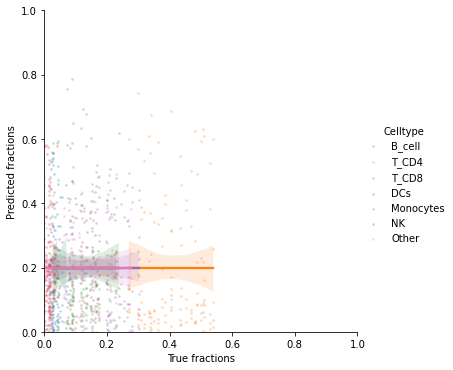

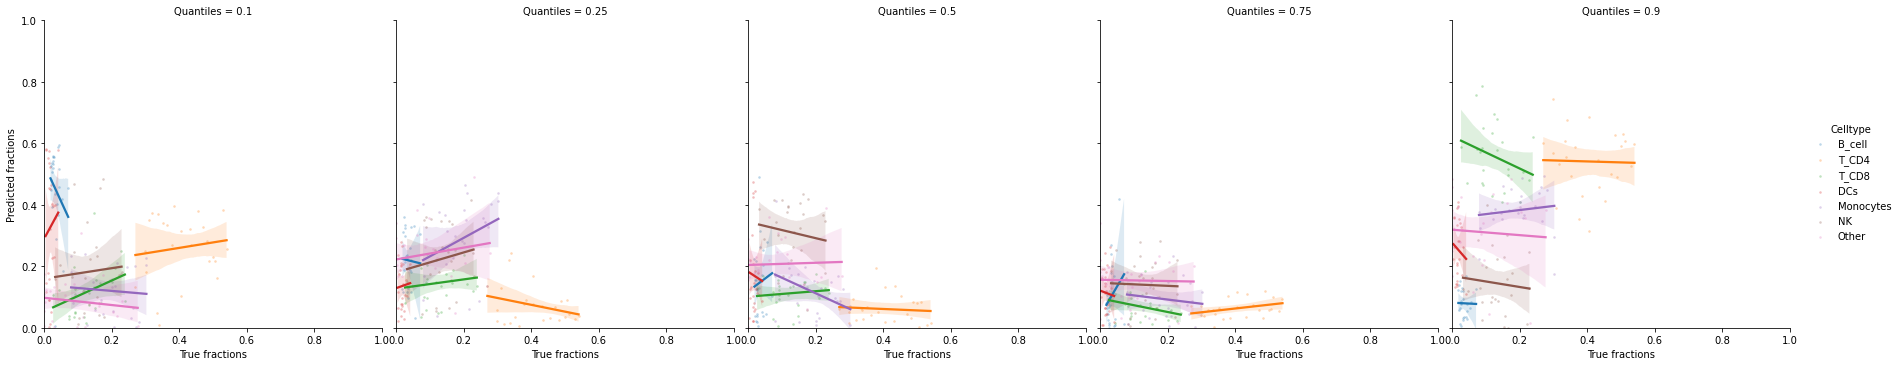

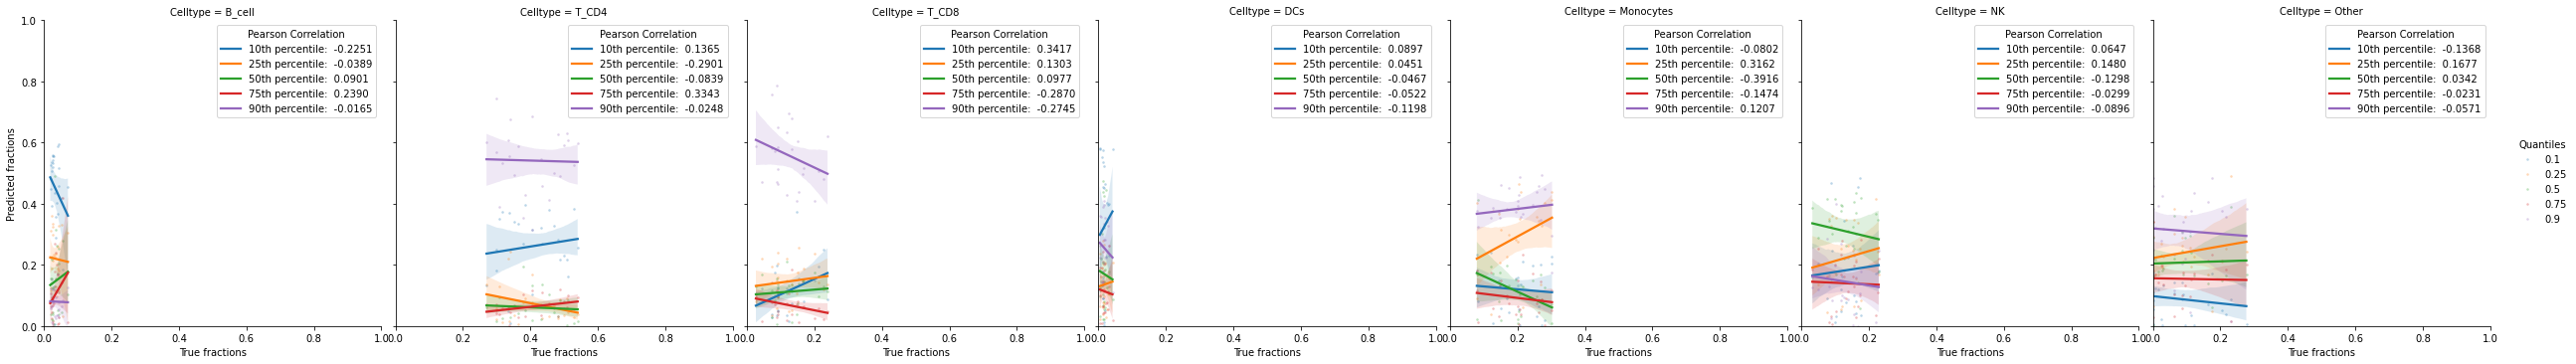

In [83]:
# Convert lists to tensors
pred = tf.abs(tf.squeeze(tf.convert_to_tensor(pred)))
true = tf.convert_to_tensor(true)
# # Apply sum-to-one constraint to results
pred = tf.math.divide_no_nan(pred, tf.math.reduce_sum(pred, keepdims=True, axis=0))

df = []

for iq in range(len(CELLTYPES)):
    # Convert to Pandas dataframes and melt dataframes to long format for plotting
    pred_ = pd.DataFrame(pred[:,iq,:].numpy().T, columns=QUANTILES).melt(var_name='Quantiles', value_name='Predicted fractions')
    pred_['Celltype'] = CELLTYPES[iq]
    true_ = pd.DataFrame(true[:,iq,:].numpy().T, columns=QUANTILES).melt(var_name='Quantiles', value_name='True fractions')
    df.append(pd.concat([pred_, true_['True fractions']], axis=1, sort=False))
df = pd.concat(df, axis=0)

# Plot scatter plot and linear regression line for all predictions
g = sns.lmplot(x='True fractions', y='Predicted fractions', 
               data=df, hue='Celltype', scatter_kws={'s':3, 'alpha':0.2})
g.set(xlim=(0,1), ylim=(0,1))
# Plot scatter plot and linear regression line for each quantile
g = sns.lmplot(x='True fractions', y='Predicted fractions', 
               data=df, hue='Celltype', col='Quantiles', scatter_kws={'s':3, 'alpha':0.2})
g.set(xlim=(0,1), ylim=(0,1))
# Plot scatter plot and linear regression line for each celltype
g = sns.lmplot(x='True fractions', y='Predicted fractions', 
               data=df, hue='Quantiles', col='Celltype', scatter_kws={'s':3, 'alpha':0.2})
g.set(xlim=(0,1), ylim=(0,1))

for C, celltype in enumerate(CELLTYPES):
    R_list=[]
    for Q in QUANTILES:
        R = pearson_correlation(tf.convert_to_tensor(df.loc[(df["Quantiles"]==Q) & (df["Celltype"] == celltype), "True fractions"], dtype='float32'), 
                                tf.convert_to_tensor(df.loc[(df["Quantiles"]==Q) & (df["Celltype"] == celltype), "Predicted fractions"])).numpy()
        R_list.append(f'{int(Q * 100)}th percentile:  {R:.4f}')
    g.axes[0,C].legend(labels=R_list, loc='upper right', title='Pearson Correlation')

#### New code training all quantiles simultaneously

In [46]:
outputs = []
x = tf.keras.layers.Input(shape=(NUM_SIG_GENES,), name='Input')
for i in range(len(QUANTILES)):
    q = QUANTILES[i]
    output = tf.keras.layers.Flatten(name=f'Flatten_{int(q*100)}th_quantile')(x)
    output = tf.keras.layers.Dense(1, activation='linear', bias_constraint=tf.keras.constraints.NonNeg(),
                                   kernel_regularizer=tf.keras.regularizers.l2(0.0001), name=f'Dense_{int(q*100)}th_quantile')(output)
    outputs.append(output)

MODEL = tf.keras.Model(inputs=x, outputs=outputs)
MODEL.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 526)]        0                                            
__________________________________________________________________________________________________
Flatten_10th_quantile (Flatten) (None, 526)          0           Input[0][0]                      
__________________________________________________________________________________________________
Flatten_25th_quantile (Flatten) (None, 526)          0           Input[0][0]                      
__________________________________________________________________________________________________
Flatten_50th_quantile (Flatten) (None, 526)          0           Input[0][0]                      
_______________________________________________________________________________________

In [29]:
loss_obj = [lambda y,f: tilted_loss(y,f,q) for q in QUANTILES]
optmzr = tf.keras.optimizers.Adam(lr=LEARN_RATE)

In [48]:
def train_model(model, data_name, train_data, test_data, celltype):
    model.compile(optimizer=optmzr, loss=loss_obj,
                 metrics=[pearson_correlation, tf.keras.metrics.RootMeanSquaredError()])
    time = datetime.now().strftime('%Y%m%d')
    if os.path.isdir(f'./log/training/{time}/') is False:
        os.mkdir(f'./log/training/{time}/')
    log_name = f'{time}/{data_name}_{celltype}'
    callback_csv = tf.keras.callbacks.CSVLogger(filename=f'./log/training/{log_name}.log')
    callback_chk = tf.keras.callbacks.ModelCheckpoint(filepath=f'./log/training/{log_name}', save_best_only=True)
    model.fit(train_data[0], train_data[1], batch_size=BATCH_SIZE, epochs=EPOCHS,
             validation_data=(test_data[0], test_data[1]), callbacks=[callback_csv, callback_chk], verbose=0)
    pred = model.predict(test_data[0], verbose=0)
    res = model.evaluate(test_data[0], test_data[1], verbose=0)
    for m,v in zip(model.metrics_names, res):
        print(f'Celltype:{celltype}  {m}: {v}')
    return pred

In [49]:
pred = []
true = []

for C in trange(len(CELLTYPES)):
    # Combine data
    train_ds = [X_train, Y_train.iloc[:,C]]
    test_ds = [X_test, Y_test.iloc[:,C]]
    # Train each quantile for each celltype
    pred.append(train_model(MODEL, 'SDY67', train_ds, test_ds, celltype=CELLTYPES[C]))
    true.append(test_ds[1])


  7%|▋         | 1/15 [00:18<04:16, 18.32s/it]

Celltype:B Naive  loss: 4605.93115234375
Celltype:B Naive  Dense_10th_quantile_loss: 674.3253784179688
Celltype:B Naive  Dense_25th_quantile_loss: 649.4310913085938
Celltype:B Naive  Dense_50th_quantile_loss: 1807.91357421875
Celltype:B Naive  Dense_75th_quantile_loss: 804.96533203125
Celltype:B Naive  Dense_90th_quantile_loss: 669.2947387695312
Celltype:B Naive  Dense_10th_quantile_pearson_correlation: 0.3284115493297577
Celltype:B Naive  Dense_10th_quantile_root_mean_squared_error: 5770.4873046875
Celltype:B Naive  Dense_25th_quantile_pearson_correlation: -0.043121326714754105
Celltype:B Naive  Dense_25th_quantile_root_mean_squared_error: 6032.6181640625
Celltype:B Naive  Dense_50th_quantile_pearson_correlation: 0.07506793737411499
Celltype:B Naive  Dense_50th_quantile_root_mean_squared_error: 14335.1982421875
Celltype:B Naive  Dense_75th_quantile_pearson_correlation: -0.039858344942331314
Celltype:B Naive  Dense_75th_quantile_root_mean_squared_error: 8952.4208984375
Celltype:B Naive

 13%|█▎        | 2/15 [00:35<03:50, 17.74s/it]

Celltype:B Ex  loss: 3596.31494140625
Celltype:B Ex  Dense_10th_quantile_loss: 461.344482421875
Celltype:B Ex  Dense_25th_quantile_loss: 566.8309326171875
Celltype:B Ex  Dense_50th_quantile_loss: 1775.901123046875
Celltype:B Ex  Dense_75th_quantile_loss: 403.82379150390625
Celltype:B Ex  Dense_90th_quantile_loss: 388.4134826660156
Celltype:B Ex  Dense_10th_quantile_pearson_correlation: 0.1407284140586853
Celltype:B Ex  Dense_10th_quantile_root_mean_squared_error: 3875.14990234375
Celltype:B Ex  Dense_25th_quantile_pearson_correlation: 0.0017314777942374349
Celltype:B Ex  Dense_25th_quantile_root_mean_squared_error: 5491.8271484375
Celltype:B Ex  Dense_50th_quantile_pearson_correlation: -0.0945228859782219
Celltype:B Ex  Dense_50th_quantile_root_mean_squared_error: 9981.6455078125
Celltype:B Ex  Dense_75th_quantile_pearson_correlation: -0.20256248116493225
Celltype:B Ex  Dense_75th_quantile_root_mean_squared_error: 4830.22216796875
Celltype:B Ex  Dense_90th_quantile_pearson_correlation:

 20%|██        | 3/15 [00:48<03:03, 15.28s/it]

Celltype:B NSM  loss: 3126.99072265625
Celltype:B NSM  Dense_10th_quantile_loss: 342.4433288574219
Celltype:B NSM  Dense_25th_quantile_loss: 419.09393310546875
Celltype:B NSM  Dense_50th_quantile_loss: 1606.61669921875
Celltype:B NSM  Dense_75th_quantile_loss: 355.6522521972656
Celltype:B NSM  Dense_90th_quantile_loss: 403.1834411621094
Celltype:B NSM  Dense_10th_quantile_pearson_correlation: -0.3868340849876404
Celltype:B NSM  Dense_10th_quantile_root_mean_squared_error: 3254.0625
Celltype:B NSM  Dense_25th_quantile_pearson_correlation: -0.18602877855300903
Celltype:B NSM  Dense_25th_quantile_root_mean_squared_error: 5079.61181640625
Celltype:B NSM  Dense_50th_quantile_pearson_correlation: -0.3284129798412323
Celltype:B NSM  Dense_50th_quantile_root_mean_squared_error: 7280.3037109375
Celltype:B NSM  Dense_75th_quantile_pearson_correlation: -0.21696509420871735
Celltype:B NSM  Dense_75th_quantile_root_mean_squared_error: 4469.24951171875
Celltype:B NSM  Dense_90th_quantile_pearson_cor

 27%|██▋       | 4/15 [00:57<02:23, 13.05s/it]

Celltype:B SM  loss: 2775.017578125
Celltype:B SM  Dense_10th_quantile_loss: 374.4341125488281
Celltype:B SM  Dense_25th_quantile_loss: 386.6933288574219
Celltype:B SM  Dense_50th_quantile_loss: 1310.5347900390625
Celltype:B SM  Dense_75th_quantile_loss: 344.4454040527344
Celltype:B SM  Dense_90th_quantile_loss: 358.90899658203125
Celltype:B SM  Dense_10th_quantile_pearson_correlation: -0.24631628394126892
Celltype:B SM  Dense_10th_quantile_root_mean_squared_error: 2794.787353515625
Celltype:B SM  Dense_25th_quantile_pearson_correlation: -0.06098534166812897
Celltype:B SM  Dense_25th_quantile_root_mean_squared_error: 4561.0751953125
Celltype:B SM  Dense_50th_quantile_pearson_correlation: -0.43665748834609985
Celltype:B SM  Dense_50th_quantile_root_mean_squared_error: 5810.90478515625
Celltype:B SM  Dense_75th_quantile_pearson_correlation: -0.024695569649338722
Celltype:B SM  Dense_75th_quantile_root_mean_squared_error: 3190.18359375
Celltype:B SM  Dense_90th_quantile_pearson_correlatio

 33%|███▎      | 5/15 [01:07<01:58, 11.83s/it]

Celltype:Plasmablasts  loss: 2646.2861328125
Celltype:Plasmablasts  Dense_10th_quantile_loss: 536.9488525390625
Celltype:Plasmablasts  Dense_25th_quantile_loss: 468.892578125
Celltype:Plasmablasts  Dense_50th_quantile_loss: 985.0770874023438
Celltype:Plasmablasts  Dense_75th_quantile_loss: 326.5023498535156
Celltype:Plasmablasts  Dense_90th_quantile_loss: 328.86395263671875
Celltype:Plasmablasts  Dense_10th_quantile_pearson_correlation: -0.1946413815021515
Celltype:Plasmablasts  Dense_10th_quantile_root_mean_squared_error: 2221.96337890625
Celltype:Plasmablasts  Dense_25th_quantile_pearson_correlation: 0.10846599191427231
Celltype:Plasmablasts  Dense_25th_quantile_root_mean_squared_error: 6205.92822265625
Celltype:Plasmablasts  Dense_50th_quantile_pearson_correlation: -0.14495864510536194
Celltype:Plasmablasts  Dense_50th_quantile_root_mean_squared_error: 4989.96826171875
Celltype:Plasmablasts  Dense_75th_quantile_pearson_correlation: -0.025063518434762955
Celltype:Plasmablasts  Dense_

 40%|████      | 6/15 [01:21<01:54, 12.73s/it]

Celltype:T CD4  loss: 1972.79150390625
Celltype:T CD4  Dense_10th_quantile_loss: 281.2241516113281
Celltype:T CD4  Dense_25th_quantile_loss: 357.62750244140625
Celltype:T CD4  Dense_50th_quantile_loss: 755.2188110351562
Celltype:T CD4  Dense_75th_quantile_loss: 318.7352600097656
Celltype:T CD4  Dense_90th_quantile_loss: 259.9848937988281
Celltype:T CD4  Dense_10th_quantile_pearson_correlation: -0.4348664879798889
Celltype:T CD4  Dense_10th_quantile_root_mean_squared_error: 2558.800048828125
Celltype:T CD4  Dense_25th_quantile_pearson_correlation: -0.41148385405540466
Celltype:T CD4  Dense_25th_quantile_root_mean_squared_error: 4115.51611328125
Celltype:T CD4  Dense_50th_quantile_pearson_correlation: -0.18189257383346558
Celltype:T CD4  Dense_50th_quantile_root_mean_squared_error: 4805.02978515625
Celltype:T CD4  Dense_75th_quantile_pearson_correlation: -0.48189741373062134
Celltype:T CD4  Dense_75th_quantile_root_mean_squared_error: 2421.90380859375
Celltype:T CD4  Dense_90th_quantile_

 47%|████▋     | 7/15 [01:31<01:34, 11.77s/it]

Celltype:T CD8  loss: 1865.9886474609375
Celltype:T CD8  Dense_10th_quantile_loss: 287.31805419921875
Celltype:T CD8  Dense_25th_quantile_loss: 431.93988037109375
Celltype:T CD8  Dense_50th_quantile_loss: 613.1173706054688
Celltype:T CD8  Dense_75th_quantile_loss: 300.5483093261719
Celltype:T CD8  Dense_90th_quantile_loss: 233.0640106201172
Celltype:T CD8  Dense_10th_quantile_pearson_correlation: -0.15711134672164917
Celltype:T CD8  Dense_10th_quantile_root_mean_squared_error: 2223.9619140625
Celltype:T CD8  Dense_25th_quantile_pearson_correlation: -0.1034284383058548
Celltype:T CD8  Dense_25th_quantile_root_mean_squared_error: 3393.21923828125
Celltype:T CD8  Dense_50th_quantile_pearson_correlation: -0.4304162561893463
Celltype:T CD8  Dense_50th_quantile_root_mean_squared_error: 4914.63037109375
Celltype:T CD8  Dense_75th_quantile_pearson_correlation: -0.22310011088848114
Celltype:T CD8  Dense_75th_quantile_root_mean_squared_error: 2238.626953125
Celltype:T CD8  Dense_90th_quantile_pe

 53%|█████▎    | 8/15 [01:44<01:25, 12.17s/it]

Celltype:Basophils LD  loss: 1736.3629150390625
Celltype:Basophils LD  Dense_10th_quantile_loss: 203.7806854248047
Celltype:Basophils LD  Dense_25th_quantile_loss: 409.5836181640625
Celltype:Basophils LD  Dense_50th_quantile_loss: 642.986083984375
Celltype:Basophils LD  Dense_75th_quantile_loss: 264.9560241699219
Celltype:Basophils LD  Dense_90th_quantile_loss: 215.05543518066406
Celltype:Basophils LD  Dense_10th_quantile_pearson_correlation: 0.05754482373595238
Celltype:Basophils LD  Dense_10th_quantile_root_mean_squared_error: 2910.40625
Celltype:Basophils LD  Dense_25th_quantile_pearson_correlation: 0.018035154789686203
Celltype:Basophils LD  Dense_25th_quantile_root_mean_squared_error: 3216.357666015625
Celltype:Basophils LD  Dense_50th_quantile_pearson_correlation: -0.16611389815807343
Celltype:Basophils LD  Dense_50th_quantile_root_mean_squared_error: 3379.203125
Celltype:Basophils LD  Dense_75th_quantile_pearson_correlation: 0.036492351442575455
Celltype:Basophils LD  Dense_75th

 60%|██████    | 9/15 [01:54<01:08, 11.42s/it]

Celltype:mDCs  loss: 1539.75146484375
Celltype:mDCs  Dense_10th_quantile_loss: 214.76519775390625
Celltype:mDCs  Dense_25th_quantile_loss: 329.6958312988281
Celltype:mDCs  Dense_50th_quantile_loss: 511.96405029296875
Celltype:mDCs  Dense_75th_quantile_loss: 240.7921905517578
Celltype:mDCs  Dense_90th_quantile_loss: 242.53297424316406
Celltype:mDCs  Dense_10th_quantile_pearson_correlation: -0.21371881663799286
Celltype:mDCs  Dense_10th_quantile_root_mean_squared_error: 2078.30712890625
Celltype:mDCs  Dense_25th_quantile_pearson_correlation: -0.3047246038913727
Celltype:mDCs  Dense_25th_quantile_root_mean_squared_error: 3244.478759765625
Celltype:mDCs  Dense_50th_quantile_pearson_correlation: -0.3734090328216553
Celltype:mDCs  Dense_50th_quantile_root_mean_squared_error: 3382.662841796875
Celltype:mDCs  Dense_75th_quantile_pearson_correlation: -0.18986093997955322
Celltype:mDCs  Dense_75th_quantile_root_mean_squared_error: 1969.6639404296875
Celltype:mDCs  Dense_90th_quantile_pearson_cor

 67%|██████▋   | 10/15 [02:02<00:51, 10.40s/it]

Celltype:pDCs  loss: 1704.741455078125
Celltype:pDCs  Dense_10th_quantile_loss: 216.50634765625
Celltype:pDCs  Dense_25th_quantile_loss: 484.5874938964844
Celltype:pDCs  Dense_50th_quantile_loss: 510.6975402832031
Celltype:pDCs  Dense_75th_quantile_loss: 257.7921142578125
Celltype:pDCs  Dense_90th_quantile_loss: 235.15689086914062
Celltype:pDCs  Dense_10th_quantile_pearson_correlation: -0.11285626143217087
Celltype:pDCs  Dense_10th_quantile_root_mean_squared_error: 1974.106689453125
Celltype:pDCs  Dense_25th_quantile_pearson_correlation: 0.1259033977985382
Celltype:pDCs  Dense_25th_quantile_root_mean_squared_error: 2637.30078125
Celltype:pDCs  Dense_50th_quantile_pearson_correlation: -0.46331778168678284
Celltype:pDCs  Dense_50th_quantile_root_mean_squared_error: 2696.339111328125
Celltype:pDCs  Dense_75th_quantile_pearson_correlation: 0.5040144920349121
Celltype:pDCs  Dense_75th_quantile_root_mean_squared_error: 1418.8992919921875
Celltype:pDCs  Dense_90th_quantile_pearson_correlation

 73%|███████▎  | 11/15 [02:14<00:42, 10.74s/it]

Celltype:Monocytes C  loss: 1404.8861083984375
Celltype:Monocytes C  Dense_10th_quantile_loss: 198.53346252441406
Celltype:Monocytes C  Dense_25th_quantile_loss: 347.5855407714844
Celltype:Monocytes C  Dense_50th_quantile_loss: 372.0477294921875
Celltype:Monocytes C  Dense_75th_quantile_loss: 288.52069091796875
Celltype:Monocytes C  Dense_90th_quantile_loss: 198.1976776123047
Celltype:Monocytes C  Dense_10th_quantile_pearson_correlation: 0.1634541004896164
Celltype:Monocytes C  Dense_10th_quantile_root_mean_squared_error: 1868.1759033203125
Celltype:Monocytes C  Dense_25th_quantile_pearson_correlation: 0.009066340513527393
Celltype:Monocytes C  Dense_25th_quantile_root_mean_squared_error: 2792.313720703125
Celltype:Monocytes C  Dense_50th_quantile_pearson_correlation: -0.12243828922510147
Celltype:Monocytes C  Dense_50th_quantile_root_mean_squared_error: 2704.9189453125
Celltype:Monocytes C  Dense_75th_quantile_pearson_correlation: 0.35016754269599915
Celltype:Monocytes C  Dense_75th_q

 80%|████████  | 12/15 [02:23<00:31, 10.50s/it]

Celltype:Monocytes I  loss: 1510.3297119140625
Celltype:Monocytes I  Dense_10th_quantile_loss: 267.75592041015625
Celltype:Monocytes I  Dense_25th_quantile_loss: 324.52294921875
Celltype:Monocytes I  Dense_50th_quantile_loss: 311.94085693359375
Celltype:Monocytes I  Dense_75th_quantile_loss: 396.99932861328125
Celltype:Monocytes I  Dense_90th_quantile_loss: 209.10952758789062
Celltype:Monocytes I  Dense_10th_quantile_pearson_correlation: 0.28301602602005005
Celltype:Monocytes I  Dense_10th_quantile_root_mean_squared_error: 1599.016357421875
Celltype:Monocytes I  Dense_25th_quantile_pearson_correlation: 0.5559695363044739
Celltype:Monocytes I  Dense_25th_quantile_root_mean_squared_error: 3044.797119140625
Celltype:Monocytes I  Dense_50th_quantile_pearson_correlation: 0.44215133786201477
Celltype:Monocytes I  Dense_50th_quantile_root_mean_squared_error: 2911.176025390625
Celltype:Monocytes I  Dense_75th_quantile_pearson_correlation: 0.2056422084569931
Celltype:Monocytes I  Dense_75th_qua

 87%|████████▋ | 13/15 [02:30<00:18,  9.34s/it]

Celltype:Monocytes NC  loss: 1437.4814453125
Celltype:Monocytes NC  Dense_10th_quantile_loss: 201.1455535888672
Celltype:Monocytes NC  Dense_25th_quantile_loss: 370.644287109375
Celltype:Monocytes NC  Dense_50th_quantile_loss: 293.95733642578125
Celltype:Monocytes NC  Dense_75th_quantile_loss: 392.6866760253906
Celltype:Monocytes NC  Dense_90th_quantile_loss: 179.04638671875
Celltype:Monocytes NC  Dense_10th_quantile_pearson_correlation: 0.2112046331167221
Celltype:Monocytes NC  Dense_10th_quantile_root_mean_squared_error: 1679.301513671875
Celltype:Monocytes NC  Dense_25th_quantile_pearson_correlation: 0.5913022756576538
Celltype:Monocytes NC  Dense_25th_quantile_root_mean_squared_error: 2561.936767578125
Celltype:Monocytes NC  Dense_50th_quantile_pearson_correlation: 0.3698251247406006
Celltype:Monocytes NC  Dense_50th_quantile_root_mean_squared_error: 2756.969482421875
Celltype:Monocytes NC  Dense_75th_quantile_pearson_correlation: 0.16863955557346344
Celltype:Monocytes NC  Dense_75

 93%|█████████▎| 14/15 [02:43<00:10, 10.51s/it]

Celltype:NK  loss: 1402.06396484375
Celltype:NK  Dense_10th_quantile_loss: 256.0721740722656
Celltype:NK  Dense_25th_quantile_loss: 450.8207702636719
Celltype:NK  Dense_50th_quantile_loss: 289.7803649902344
Celltype:NK  Dense_75th_quantile_loss: 223.91473388671875
Celltype:NK  Dense_90th_quantile_loss: 181.47491455078125
Celltype:NK  Dense_10th_quantile_pearson_correlation: -0.15613774955272675
Celltype:NK  Dense_10th_quantile_root_mean_squared_error: 1432.107421875
Celltype:NK  Dense_25th_quantile_pearson_correlation: -0.11299348622560501
Celltype:NK  Dense_25th_quantile_root_mean_squared_error: 2204.5439453125
Celltype:NK  Dense_50th_quantile_pearson_correlation: 0.10857055336236954
Celltype:NK  Dense_50th_quantile_root_mean_squared_error: 2726.681396484375
Celltype:NK  Dense_75th_quantile_pearson_correlation: -0.024488648399710655
Celltype:NK  Dense_75th_quantile_root_mean_squared_error: 1252.876953125
Celltype:NK  Dense_90th_quantile_pearson_correlation: -0.06207789480686188
Cellty

100%|██████████| 15/15 [02:55<00:00, 11.70s/it]

Celltype:Other  loss: 1298.82666015625
Celltype:Other  Dense_10th_quantile_loss: 291.515625
Celltype:Other  Dense_25th_quantile_loss: 357.37030029296875
Celltype:Other  Dense_50th_quantile_loss: 247.99429321289062
Celltype:Other  Dense_75th_quantile_loss: 219.79852294921875
Celltype:Other  Dense_90th_quantile_loss: 182.1467742919922
Celltype:Other  Dense_10th_quantile_pearson_correlation: 0.399257093667984
Celltype:Other  Dense_10th_quantile_root_mean_squared_error: 1281.8809814453125
Celltype:Other  Dense_25th_quantile_pearson_correlation: 0.46767333149909973
Celltype:Other  Dense_25th_quantile_root_mean_squared_error: 2619.45703125
Celltype:Other  Dense_50th_quantile_pearson_correlation: 0.4664459228515625
Celltype:Other  Dense_50th_quantile_root_mean_squared_error: 2118.164306640625
Celltype:Other  Dense_75th_quantile_pearson_correlation: 0.3993508219718933
Celltype:Other  Dense_75th_quantile_root_mean_squared_error: 2359.12646484375
Celltype:Other  Dense_90th_quantile_pearson_corre

In [33]:
model = tf.keras.models.load_model('./log/training/20210331/simbulk_B_cell', custom_objects={'pearson_correlation':pearson_correlation}, compile=False)
model.predict(test_ds[0])[0]

array([[0.1807014 ],
       [0.16022474],
       [0.11581292],
       ...,
       [0.14443079],
       [0.11154138],
       [0.55869275]], dtype=float32)

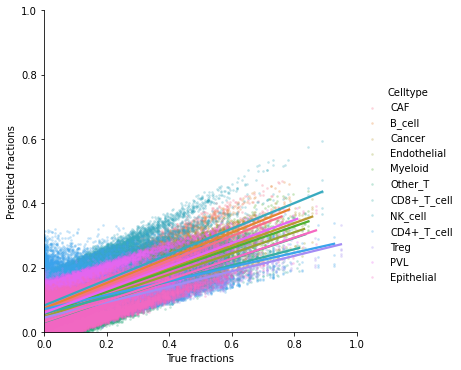

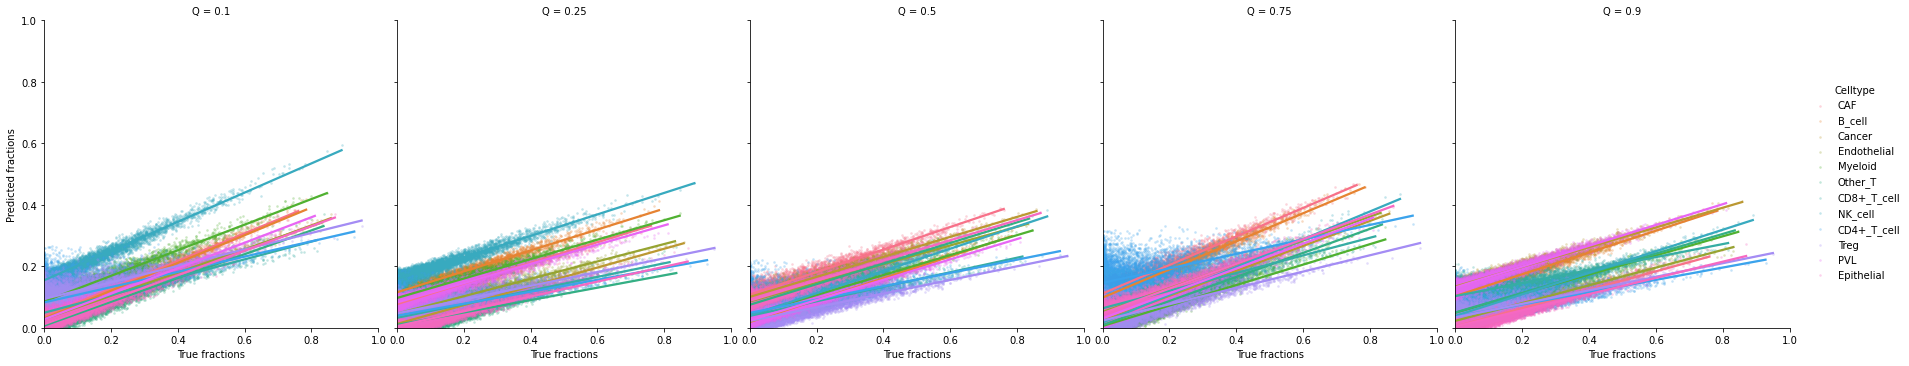

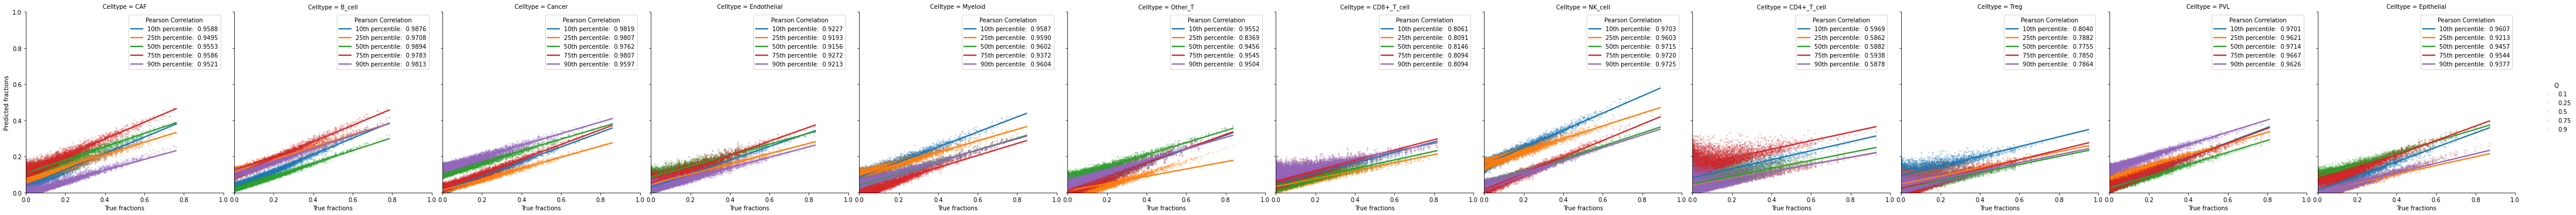

In [63]:
# Convert lists to tensors
pred = tf.abs(tf.squeeze(tf.convert_to_tensor(pred)))
true = tf.convert_to_tensor(true)
# # Apply sum-to-one constraint to results
pred = tf.math.divide_no_nan(pred, tf.math.reduce_sum(pred, keepdims=True, axis=0))

df = []

for iq in range(len(QUANTILES)):
    # Convert to Pandas dataframes and melt dataframes to long format for plotting
    pred_ = pd.DataFrame(pred[:,iq,:].numpy().T, columns=CELLTYPES).melt(var_name='Celltype', value_name='Predicted fractions')
    pred_['Q'] = QUANTILES[iq]
    true_ = pd.DataFrame(true.numpy().T, columns=CELLTYPES).melt(var_name='Celltype', value_name='True fractions')
    df.append(pd.concat([pred_, true_['True fractions']], axis=1, sort=False))
df = pd.concat(df, axis=0)

# Plot scatter plot and linear regression line for all predictions
g = sns.lmplot(x='True fractions', y='Predicted fractions', 
               data=df, hue='Celltype', scatter_kws={'s':3, 'alpha':0.2})
g.set(xlim=(0,1), ylim=(0,1))
# Plot scatter plot and linear regression line for each quantile
g = sns.lmplot(x='True fractions', y='Predicted fractions', 
               data=df, hue='Celltype', col='Q', scatter_kws={'s':3, 'alpha':0.2})
g.set(xlim=(0,1), ylim=(0,1))
# Plot scatter plot and linear regression line for each celltype
g = sns.lmplot(x='True fractions', y='Predicted fractions', 
               data=df, hue='Q', col='Celltype', scatter_kws={'s':3, 'alpha':0.2})
g.set(xlim=(0,1), ylim=(0,1))

for C, celltype in enumerate(CELLTYPES):
    R_list=[]
    for Q in QUANTILES:
        R = pearson_correlation(tf.convert_to_tensor(df.loc[(df["Q"]==Q) & (df["Celltype"] == celltype), "True fractions"], dtype='float32'), 
                                tf.convert_to_tensor(df.loc[(df["Q"]==Q) & (df["Celltype"] == celltype), "Predicted fractions"])).numpy()
        R_list.append(f'{int(Q * 100)}th percentile:  {R:.4f}')
    g.axes[0,C].legend(labels=R_list, loc='upper right', title='Pearson Correlation')

In [64]:
def MinMaxNorm(x):
    x_scaled = tf.math.divide_no_nan(
        (x - tf.math.reduce_min(x)),
        (tf.math.reduce_max(x) - tf.math.reduce_min(x)))
    return x_scaled

def data_loader(path, genes=None, rowname=None, colname=None, normalize=False):
    data = pd.read_csv(path, index_col=rowname, header=colname)
    data = data.dropna(axis=1)
    data = data.T
    if genes is not None:
        data = data.loc[:,data.columns.isin(genes)].sort_index(axis=1)
    data = data.values.astype(float)
    if normalize:
        data = MinMaxNorm(tf.math.log1p(data))
        data = data.numpy()
#     data = data.reshape(-1, data.shape[1], 1)
    return data

In [65]:
X1 = data_loader('../DATA/SDY67/SDY67_468.csv', features, rowname=0, colname=0, normalize=True)
Y1 = data_loader('../DATA/SDY67/SDY67_468_label.csv', rowname=0, colname=0, normalize=False)

In [82]:
CELLTYPES_SDY = ['Other', 'B_cell', 'Other', 'Other', 'Monocyte', 'Other', 'CD8+_T_cell', 'NK_cell', 
                'CD4+_T_cell', 'CD4+_T_cell', 'Other', 'Other']
SDY_HEADER = ['B_cell', 'CD4+_T_cell', 'CD8+_T_cell','NK_cell','Monocyte','Other']

In [111]:
pred = []

for C in tqdm(range(len(CELLTYPES))):
    model = tf.keras.models.load_model(f'./log/training/20210331/simbulk_{CELLTYPES[C]}', custom_objects={'pearson_correlation':pearson_correlation}, compile=False)
    # Train each quantile for each celltype
    pred.append(model.predict(X1, verbose=0))
    
true = []
for C in tqdm(range(len(SDY_HEADER))):
    true.append(Y1.T[:,C])


In [112]:
# Convert lists to tensors
pred = tf.squeeze(tf.convert_to_tensor(pred))
pred = tf.math.maximum(pred, tf.zeros_like(pred))
true = tf.convert_to_tensor(true)
# Apply sum-to-one constraint to results
pred = tf.math.divide_no_nan(pred, tf.math.reduce_sum(pred, keepdims=True, axis=0))

In [110]:
Y1.T.shape

(467, 6)

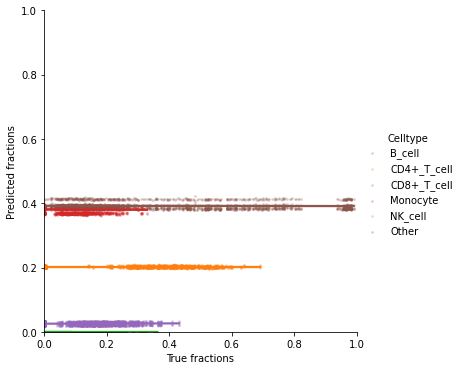

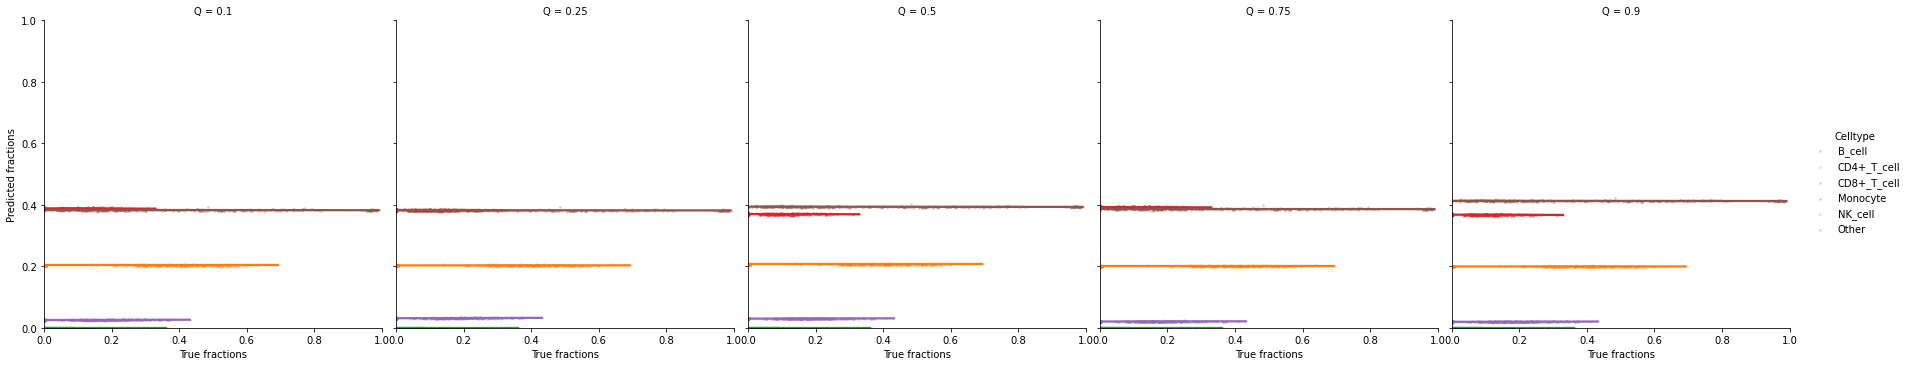

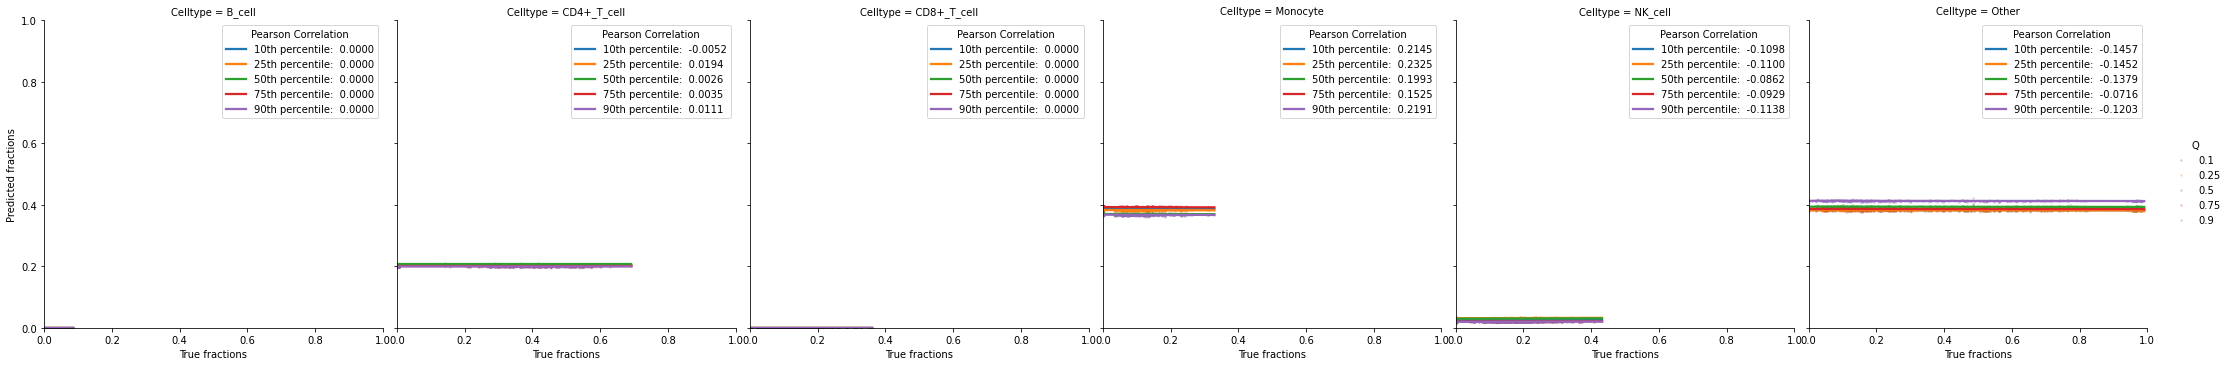

In [113]:
df = []

for iq in range(len(QUANTILES)):
    # Convert to Pandas dataframes and melt dataframes to long format for plotting
    pred_ = pd.DataFrame(pred[:,iq,:].numpy().T, columns=CELLTYPES_SDY)
    pred_ = pred_.groupby(by=pred_.columns,axis=1).sum().melt(var_name='Celltype', value_name='Predicted fractions')
    pred_['Q'] = QUANTILES[iq]
    true_ = pd.DataFrame(true.numpy().T, columns=SDY_HEADER).melt(var_name='Celltype', value_name='True fractions')
    df.append(pd.concat([pred_, true_['True fractions']], axis=1, sort=False))
df = pd.concat(df, axis=0)

# Plot scatter plot and linear regression line for all predictions
g = sns.lmplot(x='True fractions', y='Predicted fractions', 
               data=df, hue='Celltype', scatter_kws={'s':3, 'alpha':0.2})
g.set(xlim=(0,1), ylim=(0,1))
# Plot scatter plot and linear regression line for each quantile
g = sns.lmplot(x='True fractions', y='Predicted fractions', 
               data=df, hue='Celltype', col='Q', scatter_kws={'s':3, 'alpha':0.2})
g.set(xlim=(0,1), ylim=(0,1))
# Plot scatter plot and linear regression line for each celltype
g = sns.lmplot(x='True fractions', y='Predicted fractions', 
               data=df, hue='Q', col='Celltype', scatter_kws={'s':3, 'alpha':0.2})
g.set(xlim=(0,1), ylim=(0,1))

for C, celltype in enumerate(SDY_HEADER):
    R_list=[]
    for Q in QUANTILES:
        R = pearson_correlation(tf.convert_to_tensor(df.loc[(df["Q"]==Q) & (df["Celltype"] == celltype), "True fractions"], dtype='float32'), 
                                tf.convert_to_tensor(df.loc[(df["Q"]==Q) & (df["Celltype"] == celltype), "Predicted fractions"])).numpy()
        R_list.append(f'{int(Q * 100)}th percentile:  {R:.4f}')
    g.axes[0,C].legend(labels=R_list, loc='upper right', title='Pearson Correlation')

### Old code training each quantile separately

In [85]:
MODEL = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(3000,)),
    tf.keras.layers.Dense(1, activation='linear', bias_constraint=tf.keras.constraints.NonNeg(),
                         kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
optmzr = tf.keras.optimizers.Adam(lr=LEARN_RATE)

In [86]:
# Pearson correlation
def pearson_correlation(y_true, y_pred):
    x = y_pred
    y = y_true
    vx = x - K.mean(x)
    vy = y - K.mean(y)
    r = K.sum(vx * vy) / (K.sqrt(K.clip(K.sum(K.square(vx)), K.epsilon(), float('inf'))) * K.sqrt(K.clip(K.sum(K.square(vy)), K.epsilon(), float('inf'))))
    return r

# Quantile regression loss
def tilted_loss(q, y, f):
    # q: Quantile to be evaluated, e.g., 0.5 for median.
    # y: True value.
    # f: Fitted or predicted value.
    e = (y - f)
    # e = custom_loss(y, f)
    return K.mean(K.maximum(q * e, (q - 1) * e), axis=-1)

In [87]:
def train_model(model, data_name, train_data, test_data, celltype, quantile):
    model.compile(optimizer=optmzr, loss=lambda y,f: tilted_loss(quantile,y,f),
                 metrics=[pearson_correlation, tf.keras.metrics.RootMeanSquaredError()])
    time = datetime.now().strftime('%Y%m%d-%H%M%S')
    log_name = f'{time}_{data_name}_{quantile}_{celltype}'
    callback_csv = tf.keras.callbacks.CSVLogger(filename=f'./log/training/{log_name}.log')
    model.fit(train_data[0], train_data[1], batch_size=BATCH_SIZE, epochs=EPOCHS,
             validation_data=(test_data[0], test_data[1]), callbacks=[callback_csv], verbose=0)
    pred = model.predict(test_data[0], verbose=0)
    res = model.evaluate(test_data[0], test_data[1], verbose=0)
    print(f'Testing data - Q:{quantile}  Celltype:{celltype}  Loss: {res[0]}  R:{res[1]}  RMSE:{res[2]}')
    return pred

Testing data - Q:0.1  Celltype:CAF  Loss: 0.01652265340089798  R:0.9974751472473145  RMSE:0.16441485285758972
Testing data - Q:0.1  Celltype:B_cell  Loss: 0.022873269394040108  R:0.9955486059188843  RMSE:0.027215005829930305
Testing data - Q:0.1  Celltype:Cancer  Loss: 0.05174674838781357  R:0.9910932779312134  RMSE:0.05903787910938263
Testing data - Q:0.1  Celltype:Endothelial  Loss: 0.03600152209401131  R:0.9937726855278015  RMSE:0.04183264076709747
Testing data - Q:0.1  Celltype:Myeloid  Loss: 0.012667651288211346  R:0.9923966526985168  RMSE:0.018191713839769363
Testing data - Q:0.1  Celltype:Other_T  Loss: 0.015106823295354843  R:0.9894720315933228  RMSE:0.1497577577829361
Testing data - Q:0.1  Celltype:CD8+_T_cell  Loss: 0.024420196190476418  R:0.9490563869476318  RMSE:0.24396094679832458
Testing data - Q:0.1  Celltype:NK_cell  Loss: 0.023242700845003128  R:0.9901317954063416  RMSE:0.23203910887241364
Testing data - Q:0.1  Celltype:CD4+_T_cell  Loss: 0.008616446517407894  R:0.8671

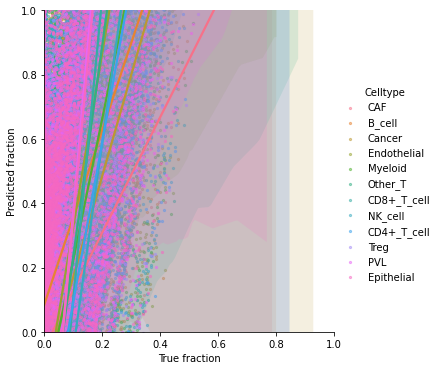

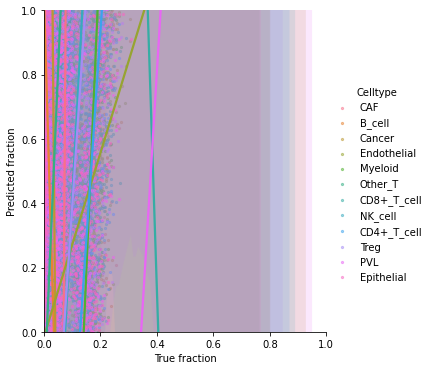

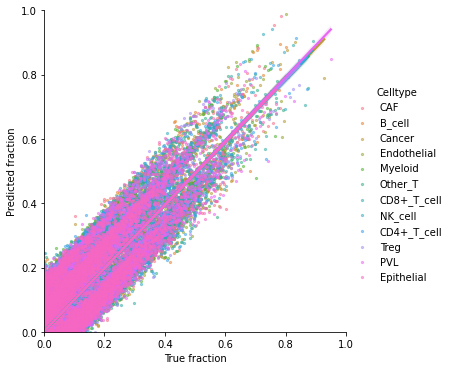

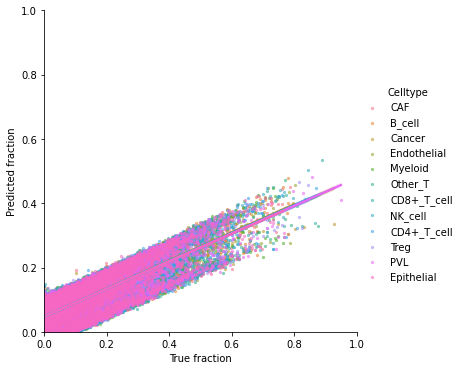

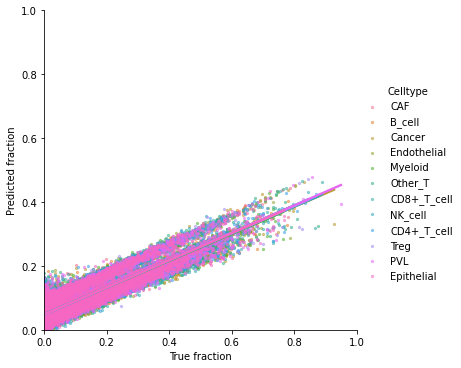

In [88]:
cols = ['Q','Celltype','Prediction']
mydata = pd.DataFrame(columns=cols)

for Q in tqdm(QUANTILES):
    pred = []
    true = []
    for C in range(len(CELLTYPES)):
        # Combine data
        train_ds = [X_train, Y_train[:,C]]
        test_ds = [X_test, Y_test[:,C]]
        # Train each quantile for each celltype
        pred.append(train_model(MODEL, 'simbulk', train_ds, test_ds, celltype=CELLTYPES[C], quantile=Q))
        true.append(test_ds[1])
    # Convert lists to tensors
    pred = tf.convert_to_tensor(pred)
    true = tf.reshape(tf.convert_to_tensor(true), (-1,len(CELLTYPES)))
    # Apply sum-to-one constraint to results
    pred = tf.reshape(tf.math.divide_no_nan(pred, K.sum(pred, axis=0)),(-1,len(CELLTYPES)))
    # Convert to Pandas dataframes
    pred = pd.DataFrame(pred.numpy(), columns=CELLTYPES)
    true = pd.DataFrame(true.numpy(), columns=CELLTYPES)
    # Melt dataframes to long format for plotting
    pred = pred.melt(var_name='Celltype', value_name='Predicted fraction')
    pred['Q'] = Q
    true = true.melt(var_name='Celltype', value_name='True fraction')
    df = pd.concat([pred, true['True fraction']], axis=1, sort=True)
    # Plot scatter plot and linear regression line for each quantile
    g = sns.lmplot(x='True fraction', y='Predicted fraction', 
                   data=df, hue='Celltype', scatter_kws={'s':5, 'alpha':0.5})
    g.set(xlim=(0,1), ylim=(0,1))
    mydata = mydata.append(df, ignore_index=True, sort=True)

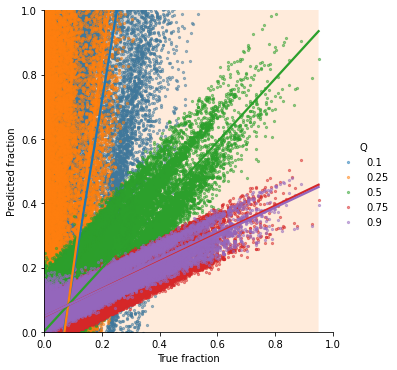

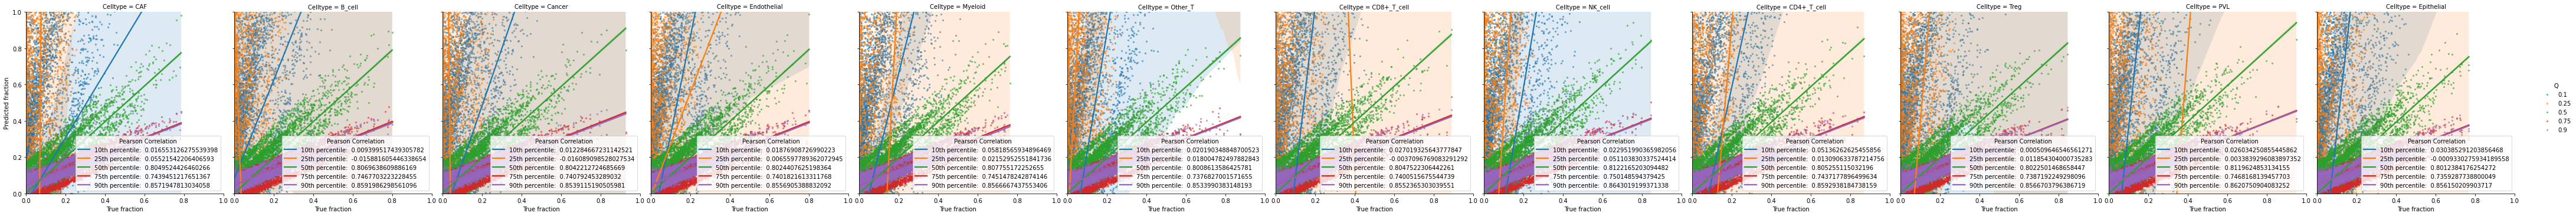

In [89]:
g = sns.lmplot(x='True fraction', y='Predicted fraction', 
               data=mydata, hue='Q', scatter_kws={'s':5, 'alpha':0.5})
g.set(xlim=(0,1), ylim=(0,1))
g = sns.lmplot(x='True fraction', y='Predicted fraction',
               data=mydata, col='Celltype', hue='Q', scatter_kws={'s':5, 'alpha':0.5})
g.set(xlim=(0,1), ylim=(0,1))
for C, celltype in enumerate(CELLTYPES):
    R_list=[]
    for Q in QUANTILES:
        R = pearson_correlation(tf.convert_to_tensor(mydata.loc[(mydata["Q"]==Q) & (mydata["Celltype"] == celltype), "True fraction"], dtype='float32'), 
                                tf.convert_to_tensor(mydata.loc[(mydata["Q"]==Q) & (mydata["Celltype"] == celltype), "Predicted fraction"])).numpy()
        R_list.append(f'{int(Q * 100)}th percentile:  {R}')
    g.axes[0,C].legend(labels=R_list, loc='lower right', title='Pearson Correlation')

In [109]:
def data_loader(path, genes=None, rowname=None, colname=None, normalize=False):
    data = pd.read_csv(path, index_col=rowname, header=colname)
    data = data.dropna(axis=1)
    data = data.T
    if genes is not None:
        data = data.loc[:,data.columns.isin(genes)].sort_index(axis=1)
    data = data.values.astype(float)
    if normalize:
        data = MinMaxNorm(tf.math.log1p(data))
        data = data.numpy()
#     data = data.reshape(-1, data.shape[1], 1)
    return data

def MinMaxNorm(x):
    x_scaled = tf.math.divide_no_nan(
        (x - tf.math.reduce_min(x)),
        (tf.math.reduce_max(x) - tf.math.reduce_min(x)))
    return x_scaled

In [ ]:
pred_X1

for C in range(len(CELLTYPES)):
    model.predict(X1)

In [ ]:
CELLTYPES = ['CAF','B_cell','Cancer','Endothelial','Myeloid','Other_T','CD8+_T_cell',
             'NK_cell','CD4+_T_cell','Treg','PVL','Epithelial']

simbulk_data_path = '../DATA/simbulk/210319_GAN_N100000_C500_simbulk_data.csv'
simbulk_label_path = '../DATA/simbulk/210319_GAN_N100000_C500_simbulk_label.csv'
test_data_path = []
bkdata_paths = ['../DATA/TCGA/TCGA_GDC_HTSeq_TPM.csv',
              '../DATA/METABRIC/METABRIC.csv',
              '../DATA/SDY67/SDY67_477.csv']

In [ ]:
class q_model:
    def __init__(self, quantiles, in_shape=3000, out_shape=12, batch_size=100):
        self.quantiles = quantiles
        self.num_quantiles = len(quantiles)
        self.in_shape = in_shape
        self.out_shape = out_shape
        self.batch_size = batch_size
        
        self.outputs = []
        self.losses = []
        self.loss_history = []
        
        self.build_model()
        
    def build_model(self, scope='q_model'):
        x = keras.Input(shape=(3000,))
        for i in range(self.num_quantiles):
            outputs = tf.keras.layers.Flatten()(x)
            outputs = tf.keras.layers.Dense(1, activation='linear', bias_constraint=tf.keras.constraints.NonNeg(),
                                      kernel_regularizer=tf.keras.regularizers.l2(0.0001))(outputs)
            self.outputs.append(outputs)
            
            error = tf.math.subtract()
            q = self.quantiles[i]
    
    def fit(self, x, y, epochs=100):
        